In [144]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from xgboost import XGBRegressor
from mpl_toolkits.mplot3d import Axes3D

In [13]:

import pandas as pd
import numpy as np
import datetime as dt

# Replace the below file name for your layout if necessary
train_raw = pd.read_csv('data/train.csv')
train = train_raw # Todo:  Add split here

test_raw = pd.read_csv('data/test.csv')
test = test_raw

# date_time conversion
dates_dt = pd.to_datetime(train['date'])
dates_dt_min = dates_dt.min()
num_dates = (dates_dt.max() - dates_dt_min).days + 1
assert num_dates == 1688
raw_date_range = np.arange(num_dates)
date_range = pd.to_timedelta(raw_date_range, unit = 'days') + dates_dt_min
date_index = pd.DataFrame(data = raw_date_range, index = date_range)

families = train['family'].unique()
num_families = 33
assert families.shape == (num_families,)
fam_index = pd.DataFrame(data = np.arange(33), index = families)[0]

# Here's the conversion
train_txf = train.copy()
train_txf['date'] = pd.to_datetime(train['date'])
train_txf['day'] = (pd.to_datetime(train['date']) - dates_dt_min).dt.days
train_txf['store_nbr'] = train['store_nbr'] - 1
train_txf['family'] = train['family'].apply(fam_index.get)

num_stores = 54

# Allocate sales array
sales_shape = (1688, 54, 33)
sales = np.zeros(dtype = np.float64, shape = sales_shape)

# Fill in the sales array
for row in train_txf.itertuples():
    day = row.day
    store = row.store_nbr
    fam = row.family
    sales[day, store, fam] = row.sales

total_sales = sales.reshape(num_dates, num_stores * num_families)
total_sales_shape = total_sales.shape

# Oil Info

oil_df = pd.read_csv('data/oil.csv')
oil_txf = oil_df.copy()
oil_txf['date'] = pd.to_datetime(oil_df['date'])
oil_txf['day_num'] = (oil_txf['date'] - dates_dt_min).dt.days
oil_txf.set_index('day_num')

# def get_oil_price(date : dt.datetime):
#     # print(date)
#     # print(date.day_of_week)
#     tgt = date
#     if date.day_of_week == 5:
#         tgt = date - dt.timedelta(days = 1)
#     if date.day_of_week == 6:
#         tgt = date - dt.timedelta(days = 2)
#     # print(tgt)
#     price = oil_txf[oil_txf['date'] == tgt]['dcoilwtico'].iloc[0]
#     return price

# time_arange = np.arange(1688)
oil_filled = pd.DataFrame(index = raw_date_range, data = {
    'day_num' : raw_date_range,
    'day' : pd.to_timedelta(raw_date_range, unit = 'days')
})
oil_filled['date'] = oil_filled['day'] + dates_dt_min
oil_filled['price'] = oil_filled['day_num'].apply(oil_txf['dcoilwtico'].get).ffill()

oil_shape = (num_dates,)
oil = oil_filled['price'].values
assert oil.shape == oil_shape

# Holiday Info

# Not entered yet.


In [151]:
X_data_59 = train_txf[(train_txf['store_nbr'] == 5) & (train_txf['family'] == 9)]
y_data_59 = X_data_59['sales']
X_data_59['lag_sale'] = X_data_59['sales'].shift(1)
X_data_59['lag_sale'][0] = 0
X_data_59['time'] = np.arange(X_data_59.shape[0])
X_data_59 = X_data_59.drop(['sales', 'date', 'id'], axis = 1)
#print(pd.date_range(start = '2013-01-01', end = '2017-08-15' ).difference(X_data_00.date))
#print(X_data_00, y_data_00)

lim = np.int64(X_data_59.shape[0] * 0.2)
X_true_train_59 = X_data_59.iloc[:lim]
X_true_test_59 = X_data_59.iloc[lim:]
y_true_train_59 = y_data_59.iloc[:lim]
y_true_test_59 = y_data_59.iloc[lim:]

C:\Users\mohao\AppData\Local\Temp\ipykernel_32408\3297176964.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_data_59['lag_sale'] = X_data_59['sales'].shift(1)
C:\Users\mohao\AppData\Local\Temp\ipykernel_32408\3297176964.py:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `d

In [152]:
# Splits data sets into training and testing data such that the testing data has $test_size$ datapoints
# Inputs: X_data, y_data: Pandas dataframes; test_size: an integer less than the number of 
#         datapoints in $X_data$ or $y_data$
# Outputs: X_train, X_test, y_train, y_test: Pandas dataframes
def train_test_split_nr(X_data, y_data, test_size): 
    assert (X_data.shape[0] == y_data.shape[0]) 
    
    split_index = X_data.shape[0] - test_size
    X_train = X_data.iloc[:split_index]
    X_test = X_data.iloc[split_index :]
    y_train = y_data.iloc[:split_index]
    y_test = y_data.iloc[split_index :]
    return X_train, X_test, y_train, y_test

In [181]:
# Applies walk forward validation for XGBoost on the training and testing sets, and computes the error for 
# all the combinations of parameters.
# Inputs: X_data, y_data: Pandas dataframes of the same number of data points
#         test_percent: an float that is the percentage of the testing data in a sample
#         n_split: an integer such that we will take $n_split$ samples from $X_data$ and $y_data$
#         params: a dictionary of parameters to be tested on. It must have three keys: 'max_depth', 'learning_rate',  
#                 and 'n_estimators', with the corresponding value being lists of integers, floats, and integers. 
#         scoring: a string that is the type of scoring. It can be "mae", "mape", or "rmse"
# Output: train_errors, test_errors: two lists whose elementss are lists with the first entries being parameters and 
#         the last entry being the corresponding training/testing errors of the XGBoost model with those parameters

def xgb_walk_forward_validation(X_data, y_data, test_percent = 0.2, n_split = 5, params = {'max_depth': [3,4,5,6,7], 'learning_rate': [0.01, 0.05, 0.1, 0.2], 'n_estimators' : [50, 100, 150, 200, 250]}, scoring = "mae"): 
    assert (X_data.shape[0] == y_data.shape[0]) and (test_percent < 0.5) and (n_split > 1)
    train_errors, test_errors = [], []
    # See the documentation of TimeSeriesSplit of scikit-learn for how we split the datasets to perform walk forward validation
    block_size = np.int64(np.floor(X_data.shape[0] /((1/test_percent) +  n_split-1)))
    num_blocks = np.int64(np.floor(1/test_percent))
    for f in range(n_split): 
        #break the f-th sample taken from the data set and split it into training and testing datasets
        X_train = X_data.iloc[0: (num_blocks-1+f)*block_size]
        X_test = X_data.iloc[(num_blocks-1+f)*block_size: (num_blocks+f)*block_size]
        y_train = y_data.iloc[0: (num_blocks-1+f)*block_size]
        y_test = y_data.iloc[(num_blocks-1+f)*block_size: (num_blocks+f)*block_size]

        # loop over the parameters
        for n in params['n_estimators']: 
            for depth in params['max_depth']: 
                for rate in params['learning_rate']: 
                    # fit the XGBRegressor model on X_train, y_train and make a prediction
                    XGBoost = XGBRegressor(objective='reg:squarederror', learning_rate=rate, n_estimators=n, max_depth=depth)
                    XGBoost.fit(X_train, y_train)
                    y_train_predict = XGBoost.predict(X_train)
                    y_test_predict = XGBoost.predict(X_test)
                        
                    # estimate prediction error
                    if scoring == "mae": 
                        train_error = mean_absolute_error(y_train, y_train_predict)
                        test_error = mean_absolute_error(y_test, y_test_predict)
                    elif scoring == "mape": 
                        train_error = mean_absolute_percentage_error(y_train, y_train_predict)
                        test_error = mean_absolute_percentage_error(y_test, y_test_predict)
                    elif scoring == "rmse": 
                        train_error = mean_squared_error(y_train, y_train_predict)
                        test_error = mean_squared_error(y_test, y_test_predict)
                    

                    train_errors.append([n, depth, rate, train_error])
                    test_errors.append([n, depth, rate, test_error])
    return train_errors, test_errors

In [228]:
# Plot test errors for different model complexities
def plot_train_test_errors(train_errors, test_errors, x_id, other_ids, other_params, scoring = 'mae'): 
    x_lbls = ['Number of Trees', 'Maximum Depth of Trees', 'Learning Rate']

    plt.figure(figsize=(14,8))
    plt.plot(train_errors[0],train_errors[1],'o',c='blue')
    plt.plot(test_errors[0],test_errors[1],'o',c='red')
    plt.legend(['training error', 'testing error'],loc=0,fontsize=8)
    ax = plt.gca()
    ax.set_xlim(0, 0.3)
    ax.set_ylim(0, 80)
    if scoring == 'mae': 
        ttl = 'Mean Absolute Error vs '+x_lbls[x_id]+'\n with '+x_lbls[other_ids[0]] + '=' + str(other_params[other_ids[0]]) + ' and '+x_lbls[other_ids[1]] + '=' + str(other_params[other_ids[1]])
        ax.set(xlabel = x_lbls[x_id], ylabel = 'Mean Absolute Error', title = ttl)
    elif scoring == 'rmse': 
        ttl = 'Root Mean Square Error vs '+x_lbls[x_id]+'\n with '+x_lbls[other_ids[0]] + '=' + str(other_params[other_ids[0]]) + 'and '+x_lbls[other_ids[1]] + '=' + str(other_params[other_ids[1]])
        ax.set(xlabel = x_lbls[x_id], ylabel = 'Root Mean Square Error', zlable = 'Root Mean Square Error', title = ttl)
    
    plt.legend()
    plt.show()


In [198]:
train_errors, test_errors = xgb_walk_forward_validation(X_true_train_59, y_true_train_59)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


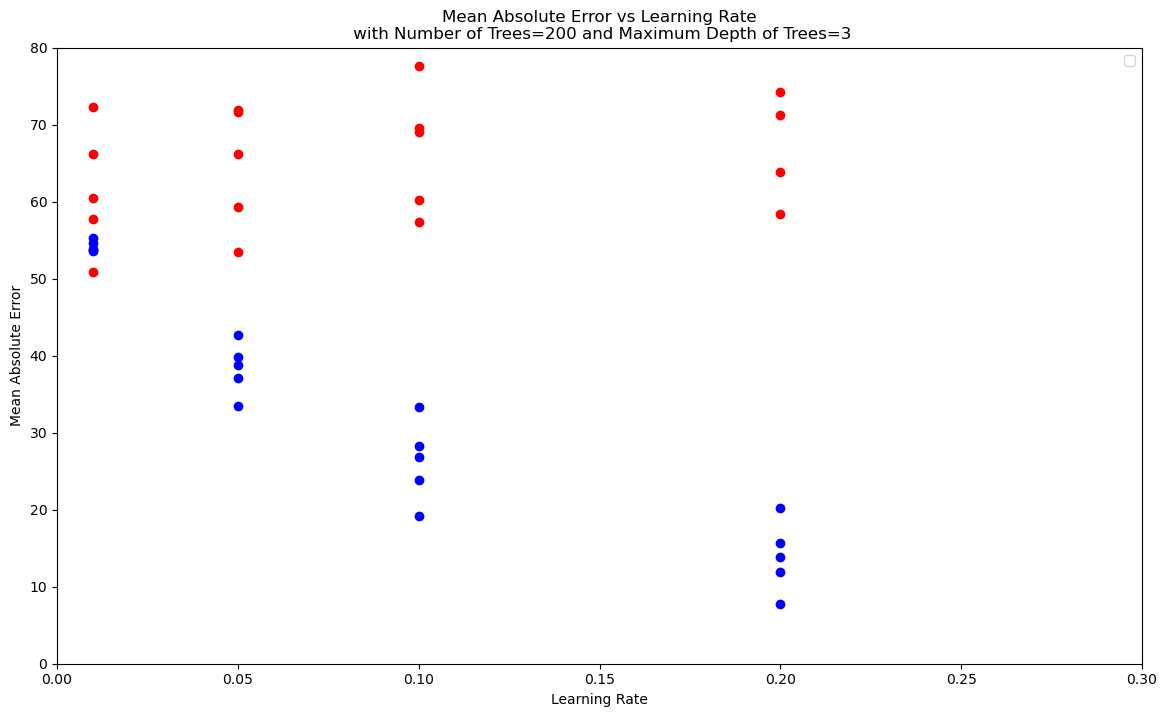

In [229]:
train_er = np.array([[x[2], x[3]] for x in train_errors if x[0] == 200 and x[1] == 3]).T
test_er = np.array([[x[2], x[3]] for x in test_errors if x[0] == 200 and x[1] == 3]).T
plot_train_test_errors(train_er, test_er, 2, [0, 1], [200, 3], scoring = 'mae')

#print(test_errors)
#print(train_errors)
#print(test_errors)
#print(mean_absolute_percentage_error(y_true_test_59.to_numpy(), train_errors))




In [166]:
def xgb_model(X_train, y_train, params): 
    rate, n, depth = params['learning_rate'], params['n_estimators'], params['max_depth']
    XGBoost = XGBRegressor(objective='reg:squarederror', learning_rate=rate, n_estimators=n, max_depth=depth)
    XGBoost.fit(X_train, y_train)
    return XGBoost


def xgb_test(model, X_test): 
    predicts = []
    for i in range(X_test.shape[0]): 
        predicts.append(model.predict(pd.DataFrame(X_test.iloc[i]).T))
    return predicts

In [174]:
params = {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
model = xgb_model(X_true_train_59, y_true_train_59, params)
predicts = xgb_test(model, X_true_test_59)

print(mean_absolute_error(y_true_test_59, predicts))
print()
def get_predictions_accuracies(model,X_train,X_test,y_train,y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    acc_train = accuracy_score(y_train, y_train_pred)
    acc_test = accuracy_score(y_test, y_test_pred)
    print(str(model.__class__),": Training Accuracy: {:.4f}, Test Accuracy: {:.4f}".format(acc_train, acc_test))
    return y_train_pred,y_test_pred,acc_train,acc_test

130.12262057416515



In [191]:
print(y_true_test_59.to_numpy())
print(predicts)

[321.972 285.567 220.601 ... 461.025 321.352 328.256]
[array([481.047], dtype=float32), array([564.1102], dtype=float32), array([413.66904], dtype=float32), array([407.81973], dtype=float32), array([534.12006], dtype=float32), array([474.34326], dtype=float32), array([536.00543], dtype=float32), array([389.96097], dtype=float32), array([409.2822], dtype=float32), array([419.75186], dtype=float32), array([361.7166], dtype=float32), array([383.5256], dtype=float32), array([509.92807], dtype=float32), array([335.77554], dtype=float32), array([419.75186], dtype=float32), array([410.7486], dtype=float32), array([405.74725], dtype=float32), array([398.16843], dtype=float32), array([401.62766], dtype=float32), array([510.97308], dtype=float32), array([354.20267], dtype=float32), array([450.39548], dtype=float32), array([428.08853], dtype=float32), array([546.93317], dtype=float32), array([497.69806], dtype=float32), array([539.09357], dtype=float32), array([538.53876], dtype=float32), array([